### <b> Code Overview </b>
##### <ul>
##### <li> Interpolate, extract CMEMS ocean, wave reanalysis data </li> 
##### <li> Combine ocean data with AIS trajectories </li>
##### <li> Define functional dependence for a given ocean/wave data, AIS vessel's type for estimation of $CO_{2}$ emission </li> 
##### </ul>   
### <b> Python libraries </b>    

In [1]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
import math 
from pathlib import Path
import xarray as xr
from IPython.display import display
import cartopy.crs as crs
xr.set_options(display_style="text")

###  <b> Load AIS trajectories data </b>  

In [2]:
base_dir = os.getcwd()

def load_AIS_traj_data(base_dir, traj_file_name):
    df = pd.read_csv(
        base_dir + traj_file_name,
        parse_dates=[0, ]
    )
    # Prepare data inside dataframe
    # Drop ETA column
    df = df.drop(columns=["ETA", ])
    # Drop values with IMO equal to zero c
    df = df[df["IMO"] > 0]
    # Eliminate paddings NAME column
    df["NAME"] = df["NAME"].str.strip()
    df["DESTINATION"] = df["DESTINATION"].str.strip()
    return df 
    
df_traj_AIS = load_AIS_traj_data(base_dir, "/baltic-sea-ais-data-master/data/4vessels-30second-2015.csv")

### <b> Extract ship's trajectories data for a selected ship IMO number </b>

In [3]:
IMO_list=np.unique(df_traj_AIS["IMO"].to_numpy())
IMO_number = IMO_list[1]
# extract data for a given IMO ship number
def extract_single_ship_data(df_traj_AIS,IMO_number):
    df_select_AIS = df_traj_AIS.loc[df_traj_AIS["IMO"]==IMO_number]
    return df_select_AIS
                                    
df_select_AIS = extract_single_ship_data(df_traj_AIS,IMO_number)                                    
print(df_select_AIS)
    

            DATE TIME (UTC)       MMSI  LATITUDE  LONGITUDE  COURSE  SPEED  \
12      2015-01-01 00:12:27  266331000  55.76277   10.81486     4.2   17.9   
14      2015-01-01 00:13:04  266331000  55.76582   10.81528     4.4   17.8   
19      2015-01-01 00:14:51  266331000  55.77459   10.81643     3.8   17.5   
27      2015-01-01 00:23:59  266331000  55.81801   10.82312     9.1   17.2   
42      2015-01-01 00:54:58  266331000  55.93477   10.98225    35.0   17.2   
...                     ...        ...       ...        ...     ...    ...   
1728264 2015-12-31 23:57:32  266331000  56.19559   11.28834   208.6   16.6   
1728266 2015-12-31 23:58:03  266331000  56.19356   11.28636   208.6   16.6   
1728268 2015-12-31 23:58:38  266331000  56.19112   11.28396   209.2   16.6   
1728270 2015-12-31 23:59:09  266331000  56.18911   11.28191   209.7   16.6   
1728273 2015-12-31 23:59:45  266331000  56.18662   11.27941   209.1   16.6   

         HEADING      IMO             NAME CALLSIGN  AISTYPE   

### <b> Calculate velocity from ship's positions </b>

In [4]:
def velocity_from_AIS_trajectory(ds_traj_AIS):
    
    lat_delta = ds_traj_AIS["LATITUDE"].diff(index)
    lon_delta = ds_traj_AIS["LONGITUDE"].diff(index)
    time_delta = ds_traj_AIS["time"].diff(index)

    ds_traj_vel = ds_traj_AIS
    r = 6.371e6  # Earth radius [m]
    #dist = 2 * r * np.arcsin((cos(np.deg2rad(df_traj_AIS["LATITUDE"]))*sin(np.deg2rad(lon_delta)/2))
    x_delta = 2 * r * np.arcsin(cos(np.deg2rad(df_traj_AIS["LATITUDE"]))*sin(np.deg2rad(lon_delta)/2)) 
    y_delta = r * np.deg2rad(lat_delta)
    ds_traj_vel['v'] = x_delta/t_delta
    ds_traj_vel['u'] = y_delta/t_delta
    ds_traj_vel['speed'] = (x_delta**2+y_delta**2)**0.5/t_delta                                 
    return ds_traj_vel
#ship_velocity = velocity_from_AIS_trajectory(df_traj_AIS)                                

### <b> Define list of ocean/ wave parameters from Copernicus data </b> 

In [5]:
# set list of ocean and wave models variables
variables_ocean_model = ['uo', 'vo'] # velocities in x direction, y direction
variables_wave_model = ['VPED', 'VSDX', 'VSDY' ] #  VSDX, VSDY sea surface wave Stokes drift x direction, y direction

### <b> Extract data from .netcdf into xarray </b>

In [6]:
dir_in = Path('data2015') / Path('global-reanalysis-phy-001-030-daily') / Path('nc')
dir_in.mkdir(parents=True, exist_ok=True)
# read model data from netcdf daily files
input_files = sorted(dir_in.glob(f"*.nc"))

def netcdf_2xarray(input_files):
    # convert files in nc directory to dataset using xarray
    ds = xr.open_mfdataset(
            input_files,
       #     parallel=True,
            concat_dim="time",
            data_vars="minimal",
            combine="by_coords",
    )
    return ds

ds_ocean = netcdf_2xarray(input_files)

dir_in = Path('data2015') / Path('global-reanalysis-wav-001-032') / Path('nc')
dir_in.mkdir(parents=True, exist_ok=True)

input_files = sorted(dir_in.glob(f"*.nc"))

ds_wave = netcdf_2xarray(input_files)

### <b> Calculate ocean current velocity and direction </b>
### <b> Calculate Stokes drift, scale wave parameters </b>

In [7]:
def ocean_surf_dir_velocity(ds_ocean):
    ds_ocean["vel_surf_curr"] = (ds_ocean["uo"] ** 2+ ds_ocean["vo"] ** 2) ** 0.5
   # ds_ocean["vel_dir_curr"]= 0.0
    ds_ocean["vel_dir_curr"] = xr.where( \
                              ((ds_ocean["vo"]**2+ds_ocean["uo"]**2)>0), \
                               np.arcsin(ds_ocean["vo"]/((ds_ocean["vo"]**2+ds_ocean["uo"]**2)**0.5))*180/np.pi, np.nan) 

def wave_scale_on(ds_wave):    
    ds_wave["Stokes_vel"] = (ds_wave["VSDX"] ** 2+ ds_wave["VSDY"] ** 2) ** 0.5
    ds_wave["VPED"] = ds_wave["VPED"]-180 

ocean_surf_dir_velocity(ds_ocean)
wave_scale_on(ds_wave)

### <b> Define domain with AIS trajectories inside </b>  

In [8]:
def define_local_domain(df_traj_AIS):
    # set margin around domain of interest in degrees

    inc_lat = 1
    inc_lon = 1

    # get mean latitude and longitude for every vessel trajectories
    lat_mean_AIS = df_traj_AIS["LATITUDE"]
    lon_mean_AIS = df_traj_AIS["LONGITUDE"]

    # set boundaries for convex region that includes AIS trajectory
    lat_view_min = lat_mean_AIS.min() - inc_lat
    lat_view_max = lat_mean_AIS.max() + inc_lat
    lon_view_min = lon_mean_AIS.min() - inc_lon
    lon_view_max = lon_mean_AIS.max() + inc_lon

    lon_border = [lon_view_min, lon_view_max]
    lat_border = [lat_view_min, lat_view_max]
    return lon_border, lat_border

lon_border, lat_border = define_local_domain(df_traj_AIS)


### <b> Interpolate ocean and wave data </b>
### <b> Combined data into a single Dataframe structure </b>
### <b> Save Dataframe reanalysis into .csv format </b> 

In [9]:
def data_interpolate(ds_wave,ds_ocean):
# Interpolate wave and ocean data to commong grid and time resolution
# combined data into a single dataframe
    ds_wave.sortby('time').resample(time = 'D').mean()
    lat_ocean = np.unique(ds_ocean["latitude"])
    lon_ocean = np.unique(ds_ocean["longitude"])
    ds_wave = ds_wave.interp(latitude=lat_ocean, \
                   longitude= lon_ocean,   \
                   method="linear")
    ds_combined = ds_ocean.squeeze("depth").drop("depth").merge(ds_wave)
    #ds_combined = ds_ocean.merge(ds_wave)
    df_combined = ds_combined.to_dataframe()
    return ds_wave, df_combined 

ds_wave, df_combined = data_interpolate(ds_wave,ds_ocean) 

#df_combined.to_csv('OceanWaveInterp2015.csv')

/home/eshchekinova/.local/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


### <b> Get ocean and wave parameters for vessel positions </b>

In [10]:
def ocean_traj_selection(ocean_data, trajectory):
    along_track_data = ocean_data.sel(
        latitude=trajectory["LATITUDE"],
        longitude=trajectory["LONGITUDE"],
        time=trajectory["DATE TIME (UTC)"],
        method="nearest"
    )
    
    # also copy vessel speeds
    along_track_data["speed"] = trajectory["SPEED"]   
    return along_track_data

# convert dataframe to dataset with ocean at ship position data    
ds_select_AIS = df_select_AIS.to_xarray()   

ocean_at_traj = ocean_traj_selection(ds_ocean, ds_select_AIS)

### <b> Plot mean ocean currents, wave information over selected domain (BALTIC SEA) </b>

/home/eshchekinova/.local/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/eshchekinova/.local/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/eshchekinova/.local/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/eshchekinova/.local/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/eshchekinova/.local/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/eshchekinova/.local/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in t

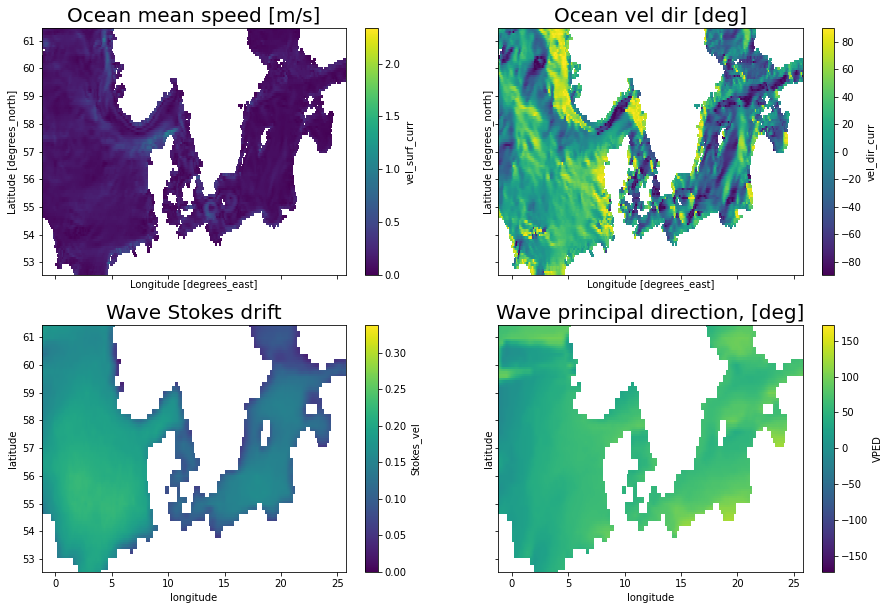

In [11]:
def plot_ocean_conditions(ds_ocean, ds_wave, lat_border, lon_border):
   
    fig, axs = plt.subplots(2, 2,  figsize=(15, 10), sharex=True, sharey=True)
    
    # Estimate maximum and minimum of ocean, wave fields  
    vel_max = ds_ocean["vel_surf_curr"].mean("time").max(axis = (0,1,2)).values
    vel_min = ds_ocean["vel_surf_curr"].mean("time").min(axis=(0,1,2)).values
    St_vel_max = ds_wave["Stokes_vel"].mean("time").max(axis=(0,1)).values
    St_vel_min = ds_wave["Stokes_vel"].mean("time").min(axis=(0,1)).values
    angle_max = ds_ocean["vel_dir_curr"].mean("time").max(axis=(0,1,2)).values
    angle_min = ds_ocean["vel_dir_curr"].mean("time").min(axis=(0,1,2)).values
    VPED_max = ds_wave["VPED"].mean("time").max(axis=(0,1)).values
    VPED_min = ds_wave["VPED"].mean("time").min(axis=(0,1)).values
    ds_ocean["vel_surf_curr"].mean("time").plot(ax=axs[0, 0], vmin = vel_min, vmax = vel_max)
    ds_ocean["vel_dir_curr"].mean("time").plot(ax=axs[0, 1], vmin = angle_min, vmax = angle_max)
    #axs[0, 0].streamplot(ds_ocean["longitude"], ds_ocean["latitude"], ds_ocean["uo"], ds_ocean["vo"], color="white", linewidth=2)
    ds_wave["Stokes_vel"].mean("time").plot(ax=axs[1, 0], vmin = St_vel_min, vmax = St_vel_max)
    ds_wave["VPED"].mean("time").plot(ax=axs[1, 1], vmin = VPED_min, vmax = VPED_max)
    axs[0, 0].set_title("Ocean mean speed [m/s]", fontsize=20)
    axs[0, 1].set_title("Ocean vel dir [deg]", fontsize=20)
    axs[1, 0].set_title("Wave Stokes drift", fontsize=20)
    axs[1, 1].set_title("Wave principal direction, [deg]", fontsize=20) 
    axs[0, 0].set_xlim(lon_border[0], lon_border[1])
    axs[0, 0].set_ylim(lat_border[0], lat_border[1])
    
# convert dataframe to dataset with ocean at ship position data    
ds_select_AIS = df_select_AIS.to_xarray()   

ocean_at_traj = ocean_traj_selection(ds_ocean, ds_select_AIS)
# plot ocean conditions
plot_ocean_conditions(ds_ocean, ds_wave, lat_border, lon_border)

### <b> Plot vessel position with IMO number  </b>
### <b> Show vessel speed, heading information </b>

/home/eshchekinova/.local/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/eshchekinova/.local/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/eshchekinova/.local/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


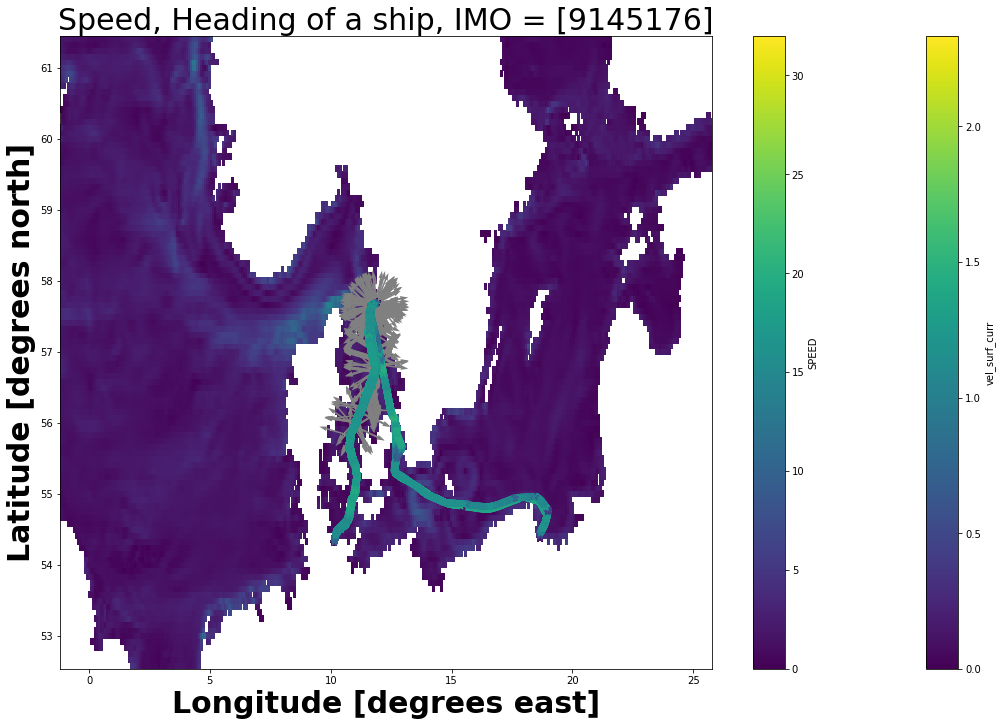

In [12]:
def plot_traj_ocean(df_select_AIF, ds_ocean, ds_wave, lat_border, lon_border):
    ds=df_select_AIF.to_xarray()
    ds=ds.assign_coords({"LONGITUDE": ds["LONGITUDE"], \
                      "LATITUDE": ds["LATITUDE"] , \
                      "DATE TIME (UTC)": ds["DATE TIME (UTC)"]})
    ds=ds.sortby("DATE TIME (UTC)")
    IMO_number = np.unique(ds["IMO"]) 
   
    fig, axs = plt.subplots(1, 1,  figsize=(15, 10))
    freq_steps_2show = 100
    x=ds.LONGITUDE[::freq_steps_2show]
    y=ds.LATITUDE[::freq_steps_2show]
    u = np.cos(np.pi/2-ds.HEADING[::freq_steps_2show])
    v = np.sin(np.pi/2-ds.HEADING[::freq_steps_2show])
    
    x_q=ds.LONGITUDE[0:1000]
    y_q=ds.LATITUDE[0:1000]
    u_q = np.cos(np.pi/2-ds.HEADING[0:1000])*10
    v_q = np.sin(np.pi/2-ds.HEADING[0:1000])*10
    
    # Estimate maximum and minimum of ocean, wave fields  
    vel_max = ds_ocean["vel_surf_curr"].mean("time").max(axis = (0,1,2)).values
    vel_min = ds_ocean["vel_surf_curr"].mean("time").min(axis=(0,1,2)).values
    fg1 = ds_ocean["vel_surf_curr"].mean("time").plot(ax=axs, vmin = vel_min, vmax = vel_max)
    #fg1 = ds.plot.scatter(x="LONGITUDE", y="LATITUDE", hue = "SPEED", marker=(5, 2))
 #   ax[0].set_title(f"SPEED of AIS traj {IMO_number}")  
    arrow = u'$\u2193$'
    Q = axs.quiver(x_q, y_q, u_q, v_q, scale = 200,facecolor='gray')#, \
    fg1 = ds.plot.scatter(x="LONGITUDE", y="LATITUDE", hue = "SPEED", marker=(5, 2))
        #        edgecolor='red' ,pivot='mid', scale = )
   # qk = axs.quiverkey(Q, 0.9, 0.9, 1, r'$1 \frac{m}{s}$', labelpos='E',
   #                coordinates='figure')
   # axs.scatter(x, y, linecolor, marker='o',markeredgecolor='r', s =2, markerfacecolor ='none')
   # axs.plot(x, y, color="white", marker='o',markeredgecolor='gray', markerfacecolor ='none')
   # show  port of origin and destination
  #  x_origin = ds.LONGITUDE.sel[ds["TIME"]==ds["TIME"].values[-1]]
    #x_arrival =
   # axs.scatter(x[0], y, marker='o',color='b', s =200)
  #  axs.scatter(x[], y, marker='o',color='g', s =200)
   # axs.plot(x, y, linestyle='none', markersize=40, marker=arrow, color='gray',\
   #             markerfacecolor='none', \
   #             markeredgecolor='gray',  \
   #             markeredgewidth=1)
   # axs.scatter(x="LONGITUDE", y="LATITUDE", s=200, facecolors='none', edgecolors='r')
    axs.set_title(f"Speed, Heading of a ship, IMO = {IMO_number}", fontsize=30)  
    #arrow = u'$\u2193$'
    #axs[0].plot(x, y, linestyle='none', markersize=20, marker=arrow)
   
    axs.set_xlim(lon_border[0], lon_border[1])
    axs.set_ylim(lat_border[0], lat_border[1])
    axs.set_xlabel('Longitude [degrees east]', fontsize=30, fontweight='bold')
    axs.set_ylabel('Latitude [degrees north]', fontsize=30, fontweight='bold')    
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    

plot_traj_ocean(df_select_AIS, ds_ocean, ds_wave, lat_border, lon_border)    